In [1]:
# importing required libraries
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

# Define paths to the pre-trained face detection model files
prototxt_path = "Face_Detector/deploy.prototxt"
weights_path = "Face_Detector/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv2.dnn.readNet(prototxt_path, weights_path)

In [15]:

def build_mask_detector_model():
    """
    This function builds a convolutional neural network (CNN) model for mask detection.

    The model uses a pre-trained MobileNetV2 base model for feature extraction and adds a custom head for classification.
    """
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    # Freeze the base model layers (don't train them)
    for layer in base_model.layers:
        layer.trainable = False

    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(128, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(1, activation="sigmoid")(head_model)  # Single output unit with sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=head_model)

    return model

mask_model = build_mask_detector_model()

# Hyperparameters for training
learning_rate = 1e-4
epochs = 20
batch_size = 32  

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
mask_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / epochs), metrics=["accuracy"])

# Data directory path
data_dir = "dataset"

# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale images to [0, 1]
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    zoom_range=0.15,  # Randomly zoom images up to 15%
    width_shift_range=0.2,  # Randomly shift images horizontally up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically up to 20%
    shear_range=0.15,  # Randomly shear images up to 15 degrees
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest"  # Fill mode for padding during augmentation
)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224 for the model
    batch_size=batch_size,
    class_mode="binary"  # Binary classification (masked/not masked)
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary"
)

# Train the model
history = mask_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // batch_size,  # Steps per epoch for training
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator) // batch_size  # Steps per epoch for validation
)

# Save the trained model
mask_model.save("mask_detector.keras")


/var/folders/fx/1pgld95125x514pcbf6f2fkr0000gn/T/ipykernel_26194/2352441280.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


Found 7553 images belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Found 7553 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 520ms/step - accuracy: 0.5598 - loss: 0.8019 - val_accuracy: 0.6518 - val_loss: 0.6084
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.5885 - loss: 0.6692 - val_accuracy: 0.7321 - val_loss: 0.5249
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.6929 - loss: 0.6118 - val_accuracy: 0.9062 - val_loss: 0.4154
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.8057 - loss: 0.4568 - val_accuracy: 0.9196 - val_loss: 0.3704
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - accuracy: 0.7923 - loss: 0.4290 - val_accuracy: 0.9330 - val_loss: 0.3139
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.8981 - loss: 0.3224 - val_accuracy: 0.9464 - val_loss: 0.2753
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.9111 - loss: 0.3040 - val_accuracy: 0.9196 - val_loss: 0.2763
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.8911 - loss: 0.3181 - val_accuracy: 0.9821 - val_loss: 0.2063
Epo

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.9242 - loss: 0.2220 - val_accuracy: 0.9509 - val_loss: 0.1995
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.9143 - loss: 0.2665 - val_accuracy: 0.9509 - val_loss: 0.1789
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.9414 - loss: 0.1990 - val_accuracy: 0.9464 - val_loss: 0.1550
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.9138 - loss: 0.2162 - val_accuracy: 0.9732 - val_loss: 0.1319
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.9378 - loss: 0.1828 - val_accuracy: 0.9464 - val_loss: 0.1411
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.9441 - loss: 0.1787 - val_accuracy: 0.9554 - val_loss: 0.1468
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.9449 - loss: 0.1779 - val_accuracy: 0.9464 - val_loss: 0.1531
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.9049 - loss: 0.2086 - val_accuracy: 0.9777 - val_loss: 0.1

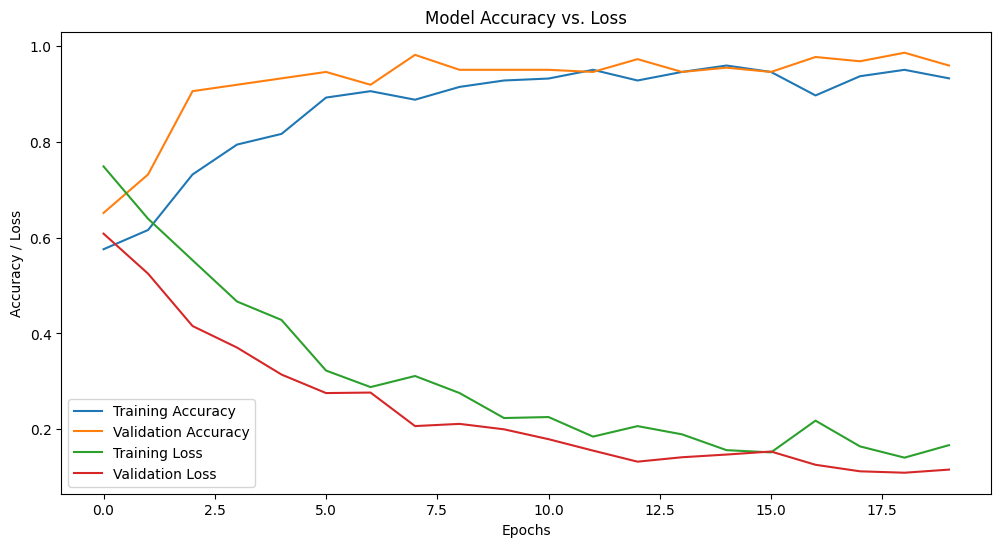

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Assuming H is the training history object obtained after training the model

# Create a figure with a specific size (12 inches wide, 6 inches high)
plt.figure(figsize=(12, 6))

# Extract training and validation accuracy from the history object
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')

# Extract training and validation loss from the history object
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')

# Set a title for the plot
plt.title('Model Accuracy vs. Loss')

# Label the x-axis (epochs) and y-axis (accuracy/loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')

# Add a legend to differentiate the lines in the plot
plt.legend()

# Display the plot
plt.show()


In [19]:
def detect_and_predict_mask(frame, face_net, mask_model):
    """
    This function detects faces in an image frame and predicts whether each face is masked or not.

    Args:
        frame: The image frame as a NumPy array.
        face_net: The pre-trained face detection model.
        mask_model: The trained mask detection model.

    Returns:
        A tuple containing:
            - locs: A list of bounding boxes for detected faces (startX, startY, endX, endY).
            - preds: A NumPy array containing the predicted probabilities of wearing a mask for each face.
    """

    (h, w) = frame.shape[:2]  # Extract frame height and width

    # Preprocess the frame for face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    faces = []
    locs = []
    preds = []

    # Loop through detected objects
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter detections based on confidence threshold (adjusted to 0.3 for potentially lower quality images)
        if confidence > 0.3:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Enforce box coordinates within frame boundaries
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Extract face region from the frame
            face = frame[startY:endY, startX:endX]

            # Handle empty face region detection
            if face.size == 0:
                print(f"Warning: Empty face region detected at {startX, startY, endX, endY}")
                continue

            # Preprocess the extracted face image for mask prediction
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # Process detected faces (if any)
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")  # Convert faces list to NumPy array
        preds = mask_model.predict(faces, batch_size=32)  # Predict mask probabilities

        # Handle potential single-output format from the model (adjust to binary classification)
        if preds.shape[-1] == 1:
            preds = np.hstack([1 - preds, preds])  # Concatenate for binary (masked/not masked)

    else:
        print("No faces detected in the frame")

    # Print informative messages
    print(f"Number of faces detected: {len(faces)}")
    print(f"Shape of preds: {preds.shape if len(preds) > 0 else 'empty'}")

    return (locs, preds)


In [ ]:
# Initialize video capture object using default camera (index 0)
cap = cv2.VideoCapture(0)

# Check if camera opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Loop continuously until user exits
while True:
    # Capture a frame from the camera
    ret, frame = cap.read()

    # Check if frame capture was successful
    if not ret:
        print("Error: Can't receive frame. Exiting ...")
        break

    # Resize the frame (optional, adjust dimensions as needed)
    try:
        frame = cv2.resize(frame, (800, 600))
    except cv2.error as e:
        print(f"Error resizing frame: {str(e)}")
        continue

    # Process the frame for face detection and mask prediction
    try:
        locs, preds = detect_and_predict_mask(frame, face_net, mask_model)

        # Handle the case where no faces were detected
        if len(locs) == 0:
            cv2.putText(frame, "No faces detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Process each detected face
        else:
            for (box, pred) in zip(locs, preds):
                (startX, startY, endX, endY) = box
                (mask, withoutMask) = pred

                # Determine mask/no mask label and color based on prediction
                label = "Mask" if mask > withoutMask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

                # Format label with predicted probability
                label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

                # Draw bounding box and label on the frame
                cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

        # Display the processed frame
        cv2.imshow("Frame", frame)

    # Catches any unexpected errors during processing and prints the traceback
    except Exception as e:
        print(f"Error processing frame: {str(e)}")
        traceback.print_exc()  # This will print the full traceback for debugging

    # Check for user input to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close windows
cap.release()
cv2.destroyAllWindows()
